### Furniture 판매 예측

In [1]:
import warnings
import itertools # 반복 가능한 데이터 스트림을 처리하는데 유용한 많은 함수와 제네레이터가 포함
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm # 통계 분석 기능을 제공하는 파이썬 패키지
import matplotlib

# 차트 기본 크기 설정
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
pd.set_option('display.max_columns', 500) # 생략 없이 출력

In [5]:
df = pd.read_excel("../data/Sample - Superstore.xls")

In [6]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [11]:
# Category가 Furniture인 것만 사용
furniture = df[df['Category'] == 'Furniture']

In [12]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [13]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

데이터 전처리

In [14]:
# 필요 없는 열 제거
# axis = 1은 행 제거를 의미(컬럼 자체를 날리는 것이 아니라 한 컬럼에서 행 하나하나씩 drop하는 원리이기 때문에)
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis = 1, inplace = True)

In [16]:
furniture = furniture.sort_values('Order Date')

In [17]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [18]:
# 누락 확인
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [21]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [22]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [24]:
# index를 Order Date로 한다.
furniture = furniture.set_index('Order Date')

In [25]:
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [26]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Resampling
시간 간격을 재조정하는 리샘플링(resampling)이 가능하다. 
이 때 시간 구간이 작아지면 데이터 양이 증가한다고 해서 업샘플링(up-sampling)이라고 하고 
시간 구간이 커지면 데이터 양이 감소한다고 해서 다운샘플링(down-sampling)이라 부른다.

In [29]:
# MS는 인덱스의 해당 월의 마지막 일자로 표시를 시작일로 변경
y = furniture['Sales'].resample('MS').mean()

In [35]:
# 2017년 매출
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

Visualizing Furniture Sales Time Series Data

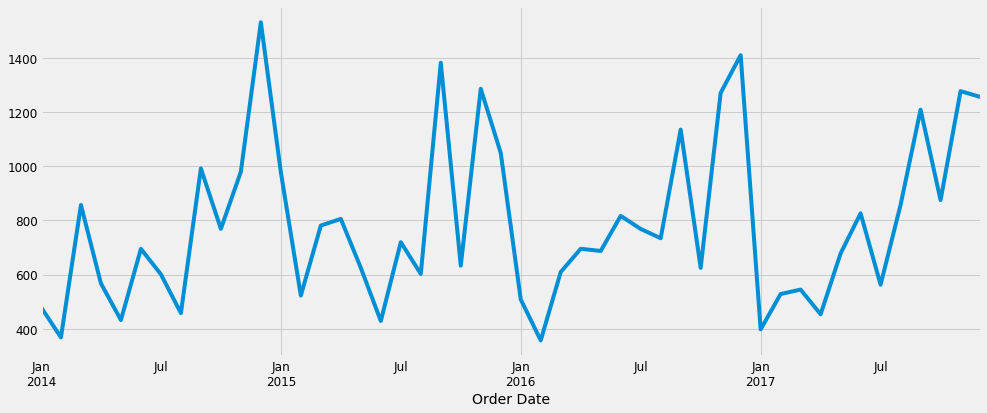

In [37]:
y.plot(figsize = (15,6))
plt.show()

연초에는 항상 매출이 낮고 연말에는 높은 계절 패턴이 있음을 확인

In [38]:
# 차트 기본 크기 설정
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

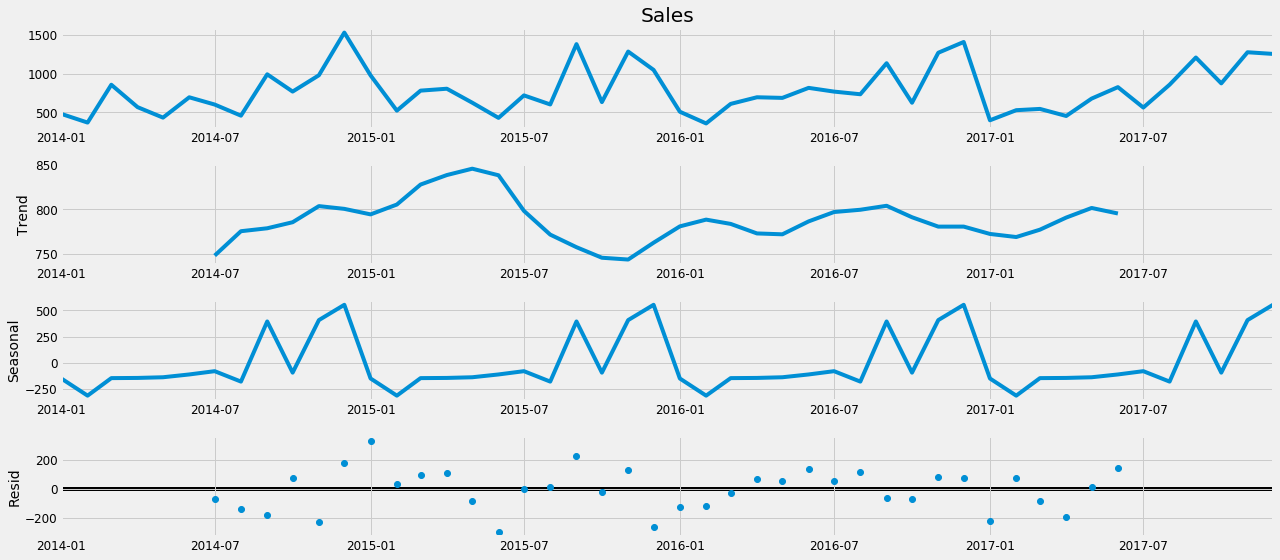

In [41]:
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

Time series forecasting with ARIMA
시계열 예측에 가장 많이 사용되는 방법인 ARIMA는 자기진행적 통합 이동 평균을 의미한다. 
ARIMA 모델은 표기법 ARIMA(p, d, q)로 표시된다.(세 가지 파라미터: 계절성, 추세, 노이즈)

In [44]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} * {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} * {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} * {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} * {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) * (0, 0, 1, 12)
SARIMAX: (0, 0, 1) * (0, 1, 0, 12)
SARIMAX: (0, 1, 0) * (0, 1, 1, 12)
SARIMAX: (0, 1, 0) * (1, 0, 0, 12)


다음은 ARIMA 모델의 파라미터 선택이다. 여기서 목표는 'grid search'를 사용하여 모델에 가장 적합한 성능을 산출하는 
최적의 매개변수 집합을 찾는 것이다.

In [46]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}*{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)*(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)*(0, 0, 1, 12)12 - AIC:1446.5593245884702


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)*(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)*(0, 1, 1, 12)12 - AIC:302.2702899793649
ARIMA(0, 0, 0)*(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)*(1, 0, 1, 12)12 - AIC:1172.2086741447833


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)*(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)*(1, 1, 1, 12)12 - AIC:304.2488280303003
ARIMA(0, 0, 1)*(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)*(0, 0, 1, 12)12 - AIC:2900.357535652858
ARIMA(0, 0, 1)*(0, 1, 0, 12)12 - AIC:466.5607429809126
ARIMA(0, 0, 1)*(0, 1, 1, 12)12 - AIC:291.6261389673277
ARIMA(0, 0, 1)*(1, 0, 0, 12)12 - AIC:499.580913309711


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)*(1, 0, 1, 12)12 - AIC:2513.1394870316744
ARIMA(0, 0, 1)*(1, 1, 0, 12)12 - AIC:319.988487694687
ARIMA(0, 0, 1)*(1, 1, 1, 12)12 - AIC:291.8725576522523
ARIMA(0, 1, 0)*(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)*(0, 0, 1, 12)12 - AIC:1250.256448915547
ARIMA(0, 1, 0)*(0, 1, 0, 12)12 - AIC:486.63785672282035


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)*(0, 1, 1, 12)12 - AIC:304.967122816796
ARIMA(0, 1, 0)*(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)*(1, 0, 1, 12)12 - AIC:1550.2028404680511
ARIMA(0, 1, 0)*(1, 1, 0, 12)12 - AIC:319.7714068109211


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)*(1, 1, 1, 12)12 - AIC:306.9113200151445
ARIMA(0, 1, 1)*(0, 0, 0, 12)12 - AIC:649.9056176817347
ARIMA(0, 1, 1)*(0, 0, 1, 12)12 - AIC:2683.886393076119
ARIMA(0, 1, 1)*(0, 1, 0, 12)12 - AIC:458.8705548482781
ARIMA(0, 1, 1)*(0, 1, 1, 12)12 - AIC:279.5806233337011
ARIMA(0, 1, 1)*(1, 0, 0, 12)12 - AIC:486.18329774427826
ARIMA(0, 1, 1)*(1, 0, 1, 12)12 - AIC:2500.937649122243
ARIMA(0, 1, 1)*(1, 1, 0, 12)12 - AIC:310.7574368417445
ARIMA(0, 1, 1)*(1, 1, 1, 12)12 - AIC:281.5576621461247
ARIMA(1, 0, 0)*(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)*(0, 0, 1, 12)12 - AIC:1338.6458117766479
ARIMA(1, 0, 0)*(0, 1, 0, 12)12 - AIC:479.46321478521355


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)*(0, 1, 1, 12)12 - AIC:304.2077675160958
ARIMA(1, 0, 0)*(1, 0, 0, 12)12 - AIC:480.92593679351967


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)*(1, 0, 1, 12)12 - AIC:1263.7349229114132
ARIMA(1, 0, 0)*(1, 1, 0, 12)12 - AIC:304.4664675084587
ARIMA(1, 0, 0)*(1, 1, 1, 12)12 - AIC:304.58426921438945
ARIMA(1, 0, 1)*(0, 0, 0, 12)12 - AIC:665.779444218685
ARIMA(1, 0, 1)*(0, 0, 1, 12)12 - AIC:82073.66352065578
ARIMA(1, 0, 1)*(0, 1, 0, 12)12 - AIC:468.3685195815054
ARIMA(1, 0, 1)*(0, 1, 1, 12)12 - AIC:293.3422193965888
ARIMA(1, 0, 1)*(1, 0, 0, 12)12 - AIC:482.5763323876739


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)*(1, 0, 1, 12)12 - AIC:nan
ARIMA(1, 0, 1)*(1, 1, 0, 12)12 - AIC:306.0156002366451
ARIMA(1, 0, 1)*(1, 1, 1, 12)12 - AIC:293.75131881197984
ARIMA(1, 1, 0)*(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)*(0, 0, 1, 12)12 - AIC:1276.5289307321336


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)*(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)*(0, 1, 1, 12)12 - AIC:300.21306116190976
ARIMA(1, 1, 0)*(1, 0, 0, 12)12 - AIC:475.34036587848493


/Users/useonsong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)*(1, 0, 1, 12)12 - AIC:1097.4755401855066
ARIMA(1, 1, 0)*(1, 1, 0, 12)12 - AIC:300.6270901345443
ARIMA(1, 1, 0)*(1, 1, 1, 12)12 - AIC:302.3264992508665
ARIMA(1, 1, 1)*(0, 0, 0, 12)12 - AIC:649.0318019835516
ARIMA(1, 1, 1)*(0, 0, 1, 12)12 - AIC:101786.44160210912
ARIMA(1, 1, 1)*(0, 1, 0, 12)12 - AIC:460.4762687609776
ARIMA(1, 1, 1)*(0, 1, 1, 12)12 - AIC:281.38730069393915
ARIMA(1, 1, 1)*(1, 0, 0, 12)12 - AIC:469.52503546607727
ARIMA(1, 1, 1)*(1, 0, 1, 12)12 - AIC:2651.570039388935
ARIMA(1, 1, 1)*(1, 1, 0, 12)12 - AIC:297.7875439546606
ARIMA(1, 1, 1)*(1, 1, 1, 12)12 - AIC:283.36610170351906


Fitting the ARIMA model

In [47]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order = (1, 1, 1),
                               seasonal_order = (1, 1, 1, 12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
result = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0949      0.313     -0.303      0.762      -0.708       0.518
ma.L1         -1.0000      0.415     -2.409      0.016      -1.814      -0.186
ar.S.L12      -0.0036      0.426     -0.008      0.993      -0.838       0.830
ma.S.L12      -0.3011      0.502     -0.599      0.549      -1.286       0.683
sigma2      2.476e+04   1.68e-05   1.48e+09      0.000    2.48e+04    2.48e+04


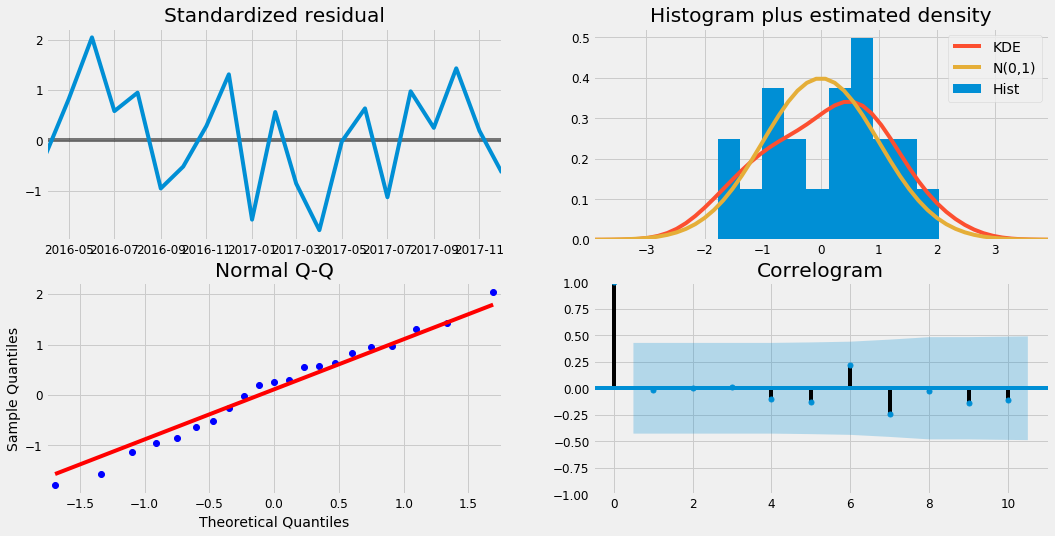

In [48]:
result.plot_diagnostics(figsize = (16, 8))
plt.show()

모델 잔차가 정규 분포에 가깝다.

Validating forecasts
예측의 정확성을 파악하기 위해 예측 판매량을 시계열의 실제 판매량과 비교하고,
2017-01-01에서 종료 시점까지 예측을 설정한다.

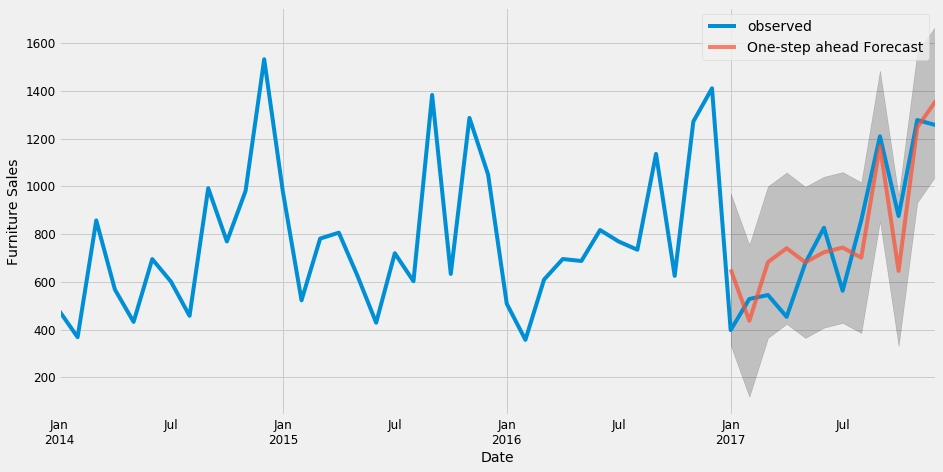

In [56]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int() # 추정된 계수의 신뢰구간 계산
ax = y['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = .7, figsize = (14, 7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [59]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 25708.96


In [60]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 160.34


Producing and visualizing forecasts

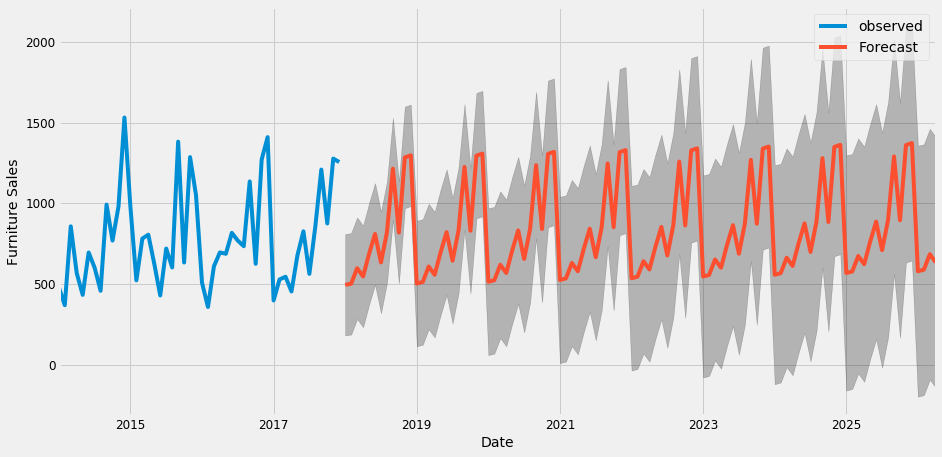

In [64]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label = 'observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = .25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()